# MNIST Code Along with ANN
Before we start working with Convolutional Neural Networks (CNN), let's model the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> using only linear layers.<br>
In this exercise we'll use the same logic laid out in the ANN notebook. We'll reshape the MNIST data from a 28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.

## Perform standard imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torch.utils.data import Subset      # it is used to split our data
from torchvision import datasets, transforms
from torchsummary import summary

from sklearn.model_selection import train_test_split # it is used to split our data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST dataset available through <a href='https://pytorch.org/vision/stable/index.html'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.
### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

### Load the training set

In [ ]:
train_data = datasets.MNIST('MNIST', download=True, train=True, transform=transform)
train_data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11632914.65it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346022.89it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3213748.98it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3082609.83it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [ ]:
test_data = datasets.MNIST('MNIST', download=True, train=False, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label.

In [ ]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

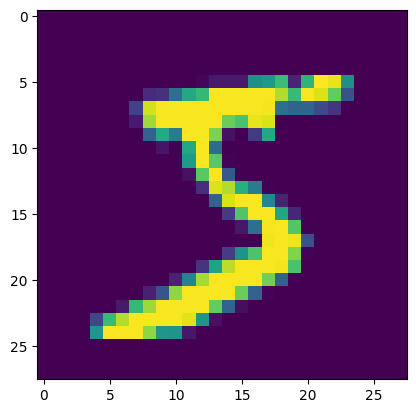

In [ ]:
cmap=None
plt.imshow(train_data[0][0].reshape((28,28)), cmap=cmap);

## Batch loading with DataLoader

This section shows how to take advantage of PyTorch's <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a> tool.
This technique becomes very helpful with large datasets.

In the cell below, the first parameter is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.

<div class="alert alert-info"><strong>NOTE:</strong> DataLoader takes an optional <tt><strong>num_workers</strong></tt> parameter that sets up how many subprocesses to use for data loading. This behaves differently with different operating systems so we've omitted it here. See <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>the docs</a> for more information.</div>

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

## Define the model
For this exercise we'll use fully connected layers to develop a <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>multilayer perceptron</a>.<br>
Our input size is 784 once we flatten the incoming 28x28 tensors.<br>
Our output size represents the 10 possible digits.<br>
We'll set our hidden layers to [128, 64] for now. Once you've completed the exercise feel free to come back and try different values.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=784, output_dim=10, layers=[128, 64]):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_dim)

    def forward(self, X):
        X = F.relu(self.fc1(X)) # hidden layer 1
        X = F.relu(self.fc2(X)) # hidden layer 2
        X = self.fc3(X)         # output layer
        return X

In [ ]:
model = MLP()

In [ ]:
# เตรียมเครื่องให้เรียกใช้ gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

summary(model, input_size=(28*28,), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Flatten the training data
The batch tensors fed in by DataLoader have a shape of [100, 1, 28, 28]:

In [ ]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break


Batch shape: torch.Size([64, 1, 28, 28])


In [ ]:
# EQUIVALENT TO:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('Batch shape:', images.size())

Batch shape: torch.Size([64, 1, 28, 28])


We can flatten them using <tt>.view()</tt>

In [ ]:
images.view(64,-1).size()

torch.Size([64, 784])

We'll do this just before applying the model to our data.

## Train the model
This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.


In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_accuracy = 0
    test_accuracy = 0
    N_train = 0
    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        N_train += X_train.shape[0]
        y_pred = model(X_train.view(X_train.shape[0], -1))  # Here, we flatten X_train by using .view()
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        batch_corr = (y_pred.argmax(dim=-1) == y_train).sum()
        train_accuracy += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_losses.append(loss.detach().cpu().numpy())

    # Print  results
    print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: { 100*train_accuracy/N_train   :7.3f}%')

    # Update training accuracy for the epoch
    train_correct.append(100*train_accuracy.item()/N_train)

    # Run the testing batches
    with torch.no_grad():
        N_test = 0
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            N_test += X_test.shape[0]

            # Apply the model
            y_pred = model(X_test.view(X_test.shape[0], -1))

            # Tally the number of correct predictions
            test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

            # calculate testing loss
            loss = criterion(y_pred, y_test)
            test_losses.append(loss.detach().cpu().numpy())

    # Update testing accuracy for the epoch
    test_correct.append(100*test_accuracy.item()/N_test)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 loss: 0.28644010 accuracy:  90.627%
epoch:  1 loss: 0.05669018 accuracy:  95.922%
epoch:  2 loss: 0.01356308 accuracy:  97.095%
epoch:  3 loss: 0.00950462 accuracy:  97.928%
epoch:  4 loss: 0.11393466 accuracy:  98.267%
epoch:  5 loss: 0.01137576 accuracy:  98.630%
epoch:  6 loss: 0.04998015 accuracy:  98.880%
epoch:  7 loss: 0.22133116 accuracy:  99.137%
epoch:  8 loss: 0.00439528 accuracy:  99.207%
epoch:  9 loss: 0.01948560 accuracy:  99.258%

Duration: 91 seconds


## Plot the loss and accuracy comparisons

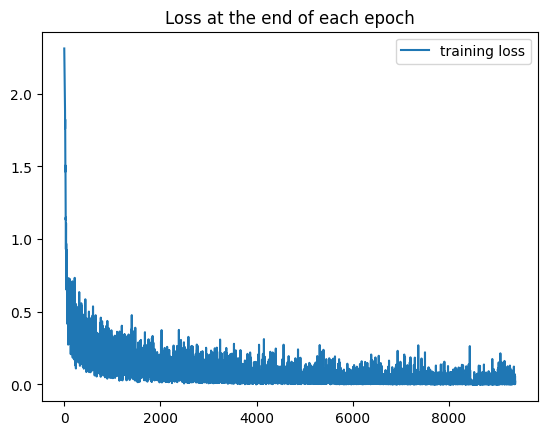

In [ ]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();

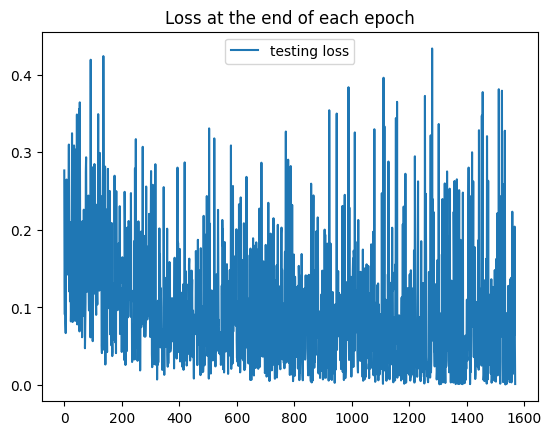

In [ ]:
plt.plot(test_losses, label='testing loss')
plt.title('Loss at the end of each epoch')
plt.legend();

This shows some evidence of overfitting the training data.

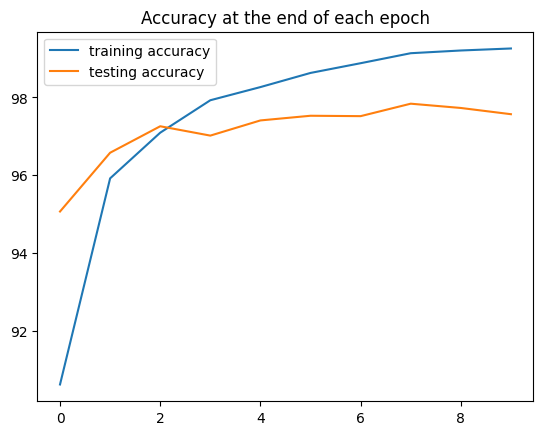

In [ ]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='testing accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# MNIST Code Along with CNN
Now that we've seen the results of an artificial neural network model on the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a>, let's work the same data with a <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Convolutional Neural Network</a> (CNN).
Make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

## Define a convolutional model
In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

**[Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) vs [Linear layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)**
<br>
**Convolutional layer parameters**:
The number of parameters $N_{p}$ in a kernel (filter) for a 2D convolution operation is
\begin{align}
N_{p} = N_{w}*N_{h}*{}N_{c}
\end{align}
where $N_{h}$ and $N_{w}$ are the height and the width of kernel, respectively.
$N_{c}$ is the number of input channels.
If we have $N_{f}$ kernels, the total number of parameters can be calculated as
\begin{align}
N_{p} = N_{w}*N_{h}*{}N_{c}*N_{f}+N_{f}
\end{align}
<br>
**Linear layer parameters**:
The total number of parameters in a dense layer is
\begin{align}
N_{p} = N_{previous}*N_{node}+N_{current}
\end{align}
where $N_{previous}$ is the number of neurons of the previous layer and $N_{current}$ is the number of neurons of the current layer.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take.</strong>

1.Extend the base Module class:

```python
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
```

2.Set up the convolutional layers with <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a>


The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter.
```python
self.conv1 = nn.Conv2d(1, 6, 3)
```

The second layer will take our 6 input channels and deliver 16 output channels.
```python
self.conv2 = nn.Conv2d(6, 16, 3)
```

3.Set up the fully connected layers with <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.

The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side.

```python
self.fc1 = nn.Linear(5*5*16, 128)
self.fc2 = nn.Linear(128, 64)
self.fc3 = nn.Linear(64, 10)
```
See below for a more detailed look at this step.

4.Define the forward method.

Activations can be applied to the convolutions in one line using <a href='https://pytorch.org/docs/stable/nn.html#id27'><tt><strong>F.relu()</strong></tt></a> and pooling is done using <a href='https://pytorch.org/docs/stable/nn.html#maxpool2d'><tt><strong>F.max_pool2d()</strong></tt></a>

```python
def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
```

Flatten the data for the fully connected layers:

```python
    X = X.view(-1, 5*5*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return X
```

<div class="alert alert-danger"><strong>Breaking down the convolutional layers</strong> (this code is for illustration purposes only.)</div>

In [ ]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3) # 1->chanel , 6->hidden node, 3->filter size
conv2 = nn.Conv2d(6, 16, 3) # 6->chanel , 16->hidden node, 3->filter size

In [ ]:
# Grab the first MNIST record
X_train, y_train = train_data[0]
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


torch.Size([1, 6, 26, 26])


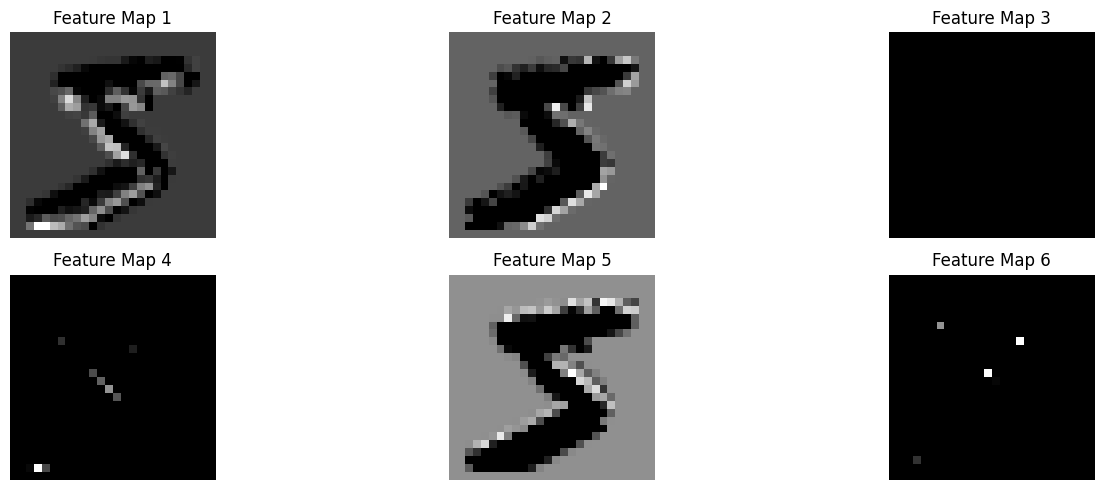

In [ ]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

num_feature_maps = x.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_feature_maps):
    plt.subplot(2, num_feature_maps // 2, i + 1)
    plt.imshow(x[0, i].detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')
plt.tight_layout()
plt.show()

torch.Size([1, 6, 13, 13])


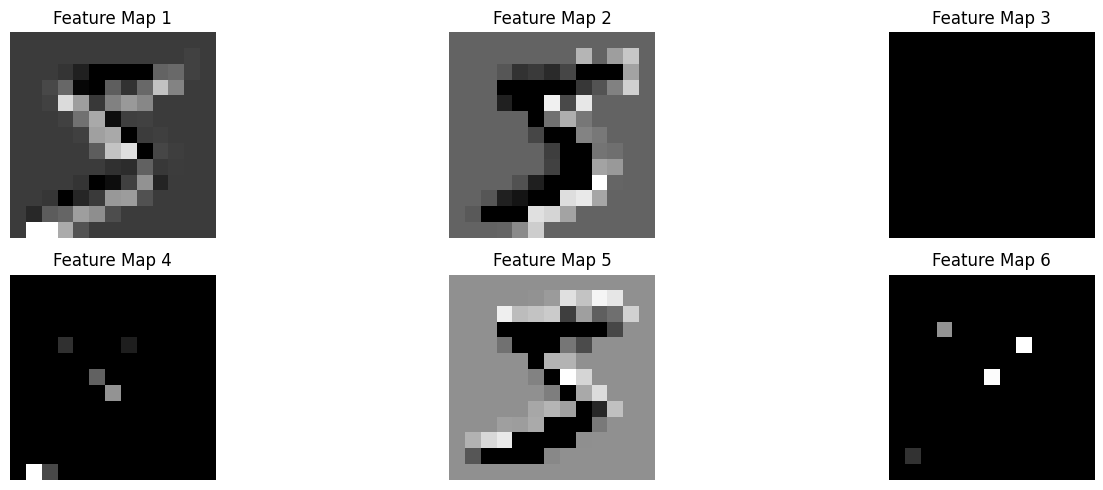

In [ ]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

num_feature_maps = x.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_feature_maps):
    plt.subplot(2, num_feature_maps // 2, i + 1)
    plt.imshow(x[0, i].detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')
plt.tight_layout()
plt.show()

torch.Size([1, 16, 11, 11])


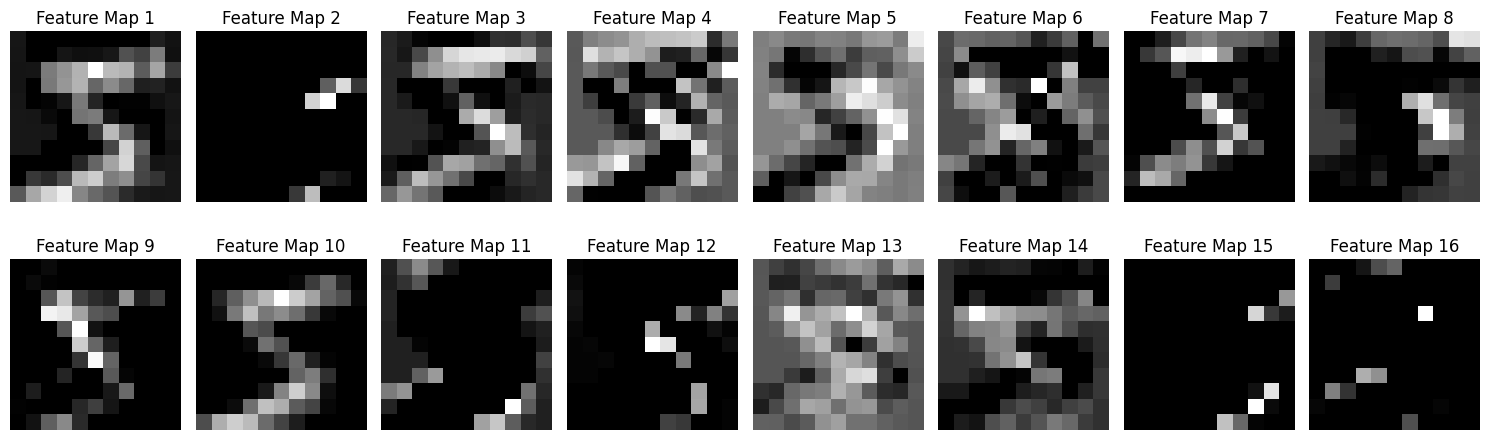

In [ ]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

num_feature_maps = x.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_feature_maps):
    plt.subplot(2, num_feature_maps // 2, i + 1)
    plt.imshow(x[0, i].detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')
plt.tight_layout()
plt.show()

torch.Size([1, 16, 5, 5])


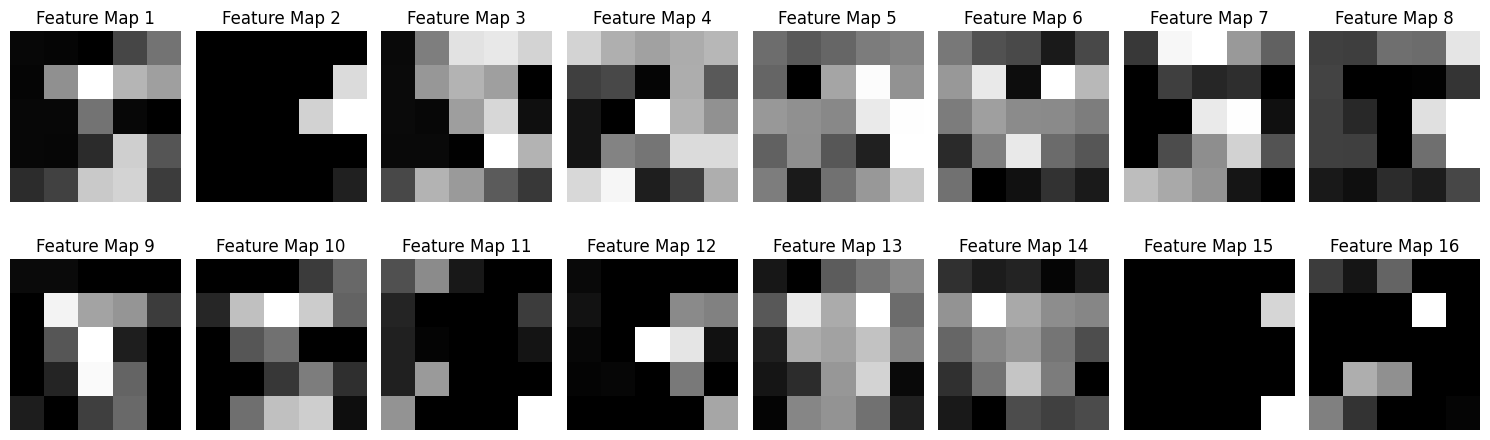

In [ ]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

num_feature_maps = x.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_feature_maps):
    plt.subplot(2, num_feature_maps // 2, i + 1)
    plt.imshow(x[0, i].detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Feature Map {i + 1}')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>This is how the convolution output is passed into the fully connected layers.</strong></div>

Now let's run the code.

In [ ]:
# padding = int
# padding = {'valid', 'same'}
conv1 = nn.Conv2d(1, 6, 3, stride=1, padding=0) # (input chanel, hidden node, filter size, stride=1, padding=0)
conv2 = nn.Conv2d(6, 16, 3, stride=1, padding=0) # (output chanel 1, hidden node, filter size, stride=1, padding=0)

batch_size = 1
input_tensor = torch.randn(batch_size, 1, 28, 28)

output = conv1(input_tensor)
print("Output shape after conv1:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

output = conv2(output)
print("Output shape after conv2:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

Output shape after conv1: torch.Size([1, 6, 26, 26])
Output shape after max_pool2d: torch.Size([1, 6, 13, 13])
Output shape after conv2: torch.Size([1, 16, 11, 11])
Output shape after max_pool2d: torch.Size([1, 16, 5, 5])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(5*5*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)

    def forward(self, X):
        # feature mapping
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # fully connected
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [ ]:
model = CNN()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

summary(model, input_size=(1, 28, 28), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
            Conv2d-2           [-1, 16, 11, 11]             880
            Linear-3                  [-1, 128]          51,328
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 10]             650
Total params: 61,174
Trainable params: 61,174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.23
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


## Define loss function & optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_accuracy = 0
    test_accuracy = 0
    N_train = 0
    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        N_train += X_train.shape[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        batch_corr = (y_pred.argmax(dim=-1) == y_train).sum()
        train_accuracy += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_losses.append(loss.detach().cpu().numpy())

    # Print  results
    print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: { 100*train_accuracy/N_train   :7.3f}%')

    # Update training accuracy for the epoch
    train_correct.append(100*train_accuracy.item()/N_train)

    # Run the testing batches
    with torch.no_grad():
        N_test = 0
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            N_test += X_test.shape[0]

            # Apply the model
            y_pred = model(X_test)

            # Tally the number of correct predictions
            test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

            # calculate testing loss
            loss = criterion(y_pred, y_test)
            test_losses.append(loss.detach().cpu().numpy())

    # Update testing accuracy for the epoch
    test_correct.append(100*test_accuracy.item()/N_test)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 loss: 0.05788943 accuracy:  88.053%
epoch:  1 loss: 0.03832167 accuracy:  96.747%
epoch:  2 loss: 0.05773813 accuracy:  97.788%
epoch:  3 loss: 0.03750723 accuracy:  98.292%
epoch:  4 loss: 0.00180356 accuracy:  98.638%
epoch:  5 loss: 0.00127398 accuracy:  98.815%
epoch:  6 loss: 0.10495751 accuracy:  98.943%
epoch:  7 loss: 0.00083891 accuracy:  99.137%
epoch:  8 loss: 0.00179812 accuracy:  99.170%
epoch:  9 loss: 0.00091870 accuracy:  99.272%

Duration: 101 seconds


## Plot the loss and accuracy comparisons

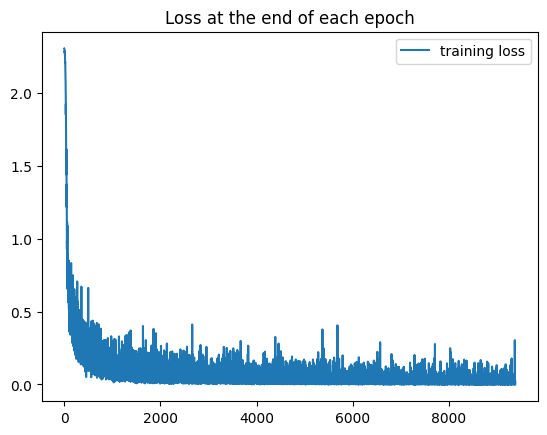

In [ ]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();

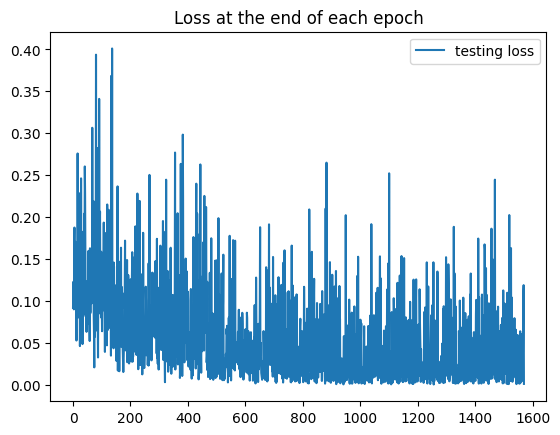

In [ ]:
plt.plot(test_losses, label='testing loss')
plt.title('Loss at the end of each epoch')
plt.legend();

This shows some evidence of overfitting the training data.

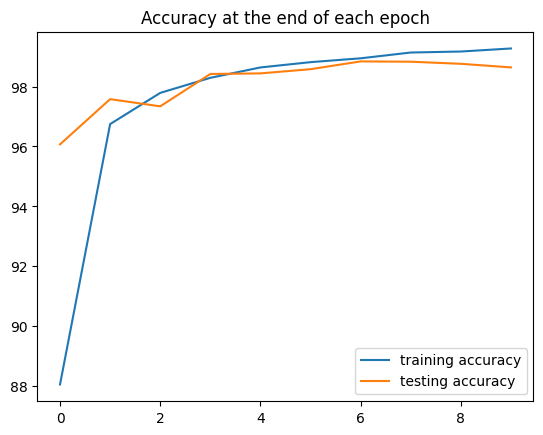

In [ ]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='testing accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Workshop

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

As with the previous code along, make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

trainset = datasets.CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='CIFAR10', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29417963.34it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


## View a batch of images

Label: [    3     3     6     4     6     6     2     1     2     1]
Class:  cat cat frog deer frog frog bird car bird car


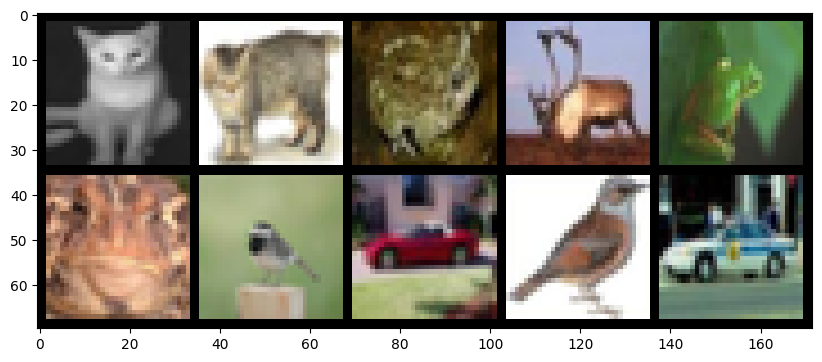

In [ ]:
from torchvision.utils import make_grid

np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

for images,labels in trainloader:
    break

# Print the labels
print('Label:', labels[:10].numpy())
print('Class: ', *np.array([classes[i] for i in labels[:10]]))

# Print the images
im = make_grid(images[:10], nrow=5)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Create your CNN based on the given architecture:

1. The first layer comprises 32 of 3x3 filters

2. The first layer comprises 16 of 3x3 filters

3. For the module of the fully connected layers, it comprises 4 linear layers with size 128, 64, 32 and 10.

4. In each layer, the ReLU function is performed as the activation function.

5. The max pooling is used in every convolution layers.

In [ ]:
#Implement
conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=0) # (input chanel, hidden node, filter size, stride=1, padding=0)
conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=0) # (output chanel 1, hidden node, filter size, stride=1, padding=0)

batch_size = 1
input_tensor = torch.randn(batch_size, 3, 32, 32)

output = conv1(input_tensor)
print("Output shape after conv1:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

output = conv2(output)
print("Output shape after conv2:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)


Output shape after conv1: torch.Size([1, 32, 30, 30])
Output shape after max_pool2d: torch.Size([1, 32, 15, 15])
Output shape after conv2: torch.Size([1, 16, 13, 13])
Output shape after max_pool2d: torch.Size([1, 16, 6, 6])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.fc1 = nn.Linear(16*6*6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,10)

    def forward(self, X):
        # feature mapping
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # fully connected
        X = X.view(-1, 16*6*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

In [ ]:
model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

summary(model, input_size=(3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 16, 13, 13]           4,624
            Linear-3                  [-1, 128]          73,856
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                   [-1, 10]             330
Total params: 90,042
Trainable params: 90,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 0.34
Estimated Total Size (MB): 0.60
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 30
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_accuracy = 0
    test_accuracy = 0
    N_train = 0
    for X_train, y_train in trainloader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        N_train += X_train.shape[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        batch_corr = (y_pred.argmax(dim=-1) == y_train).sum()
        train_accuracy += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_losses.append(loss.detach().cpu().numpy())

    # Print  results
    print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: { 100*train_accuracy/N_train   :7.3f}%')

    # Update training accuracy for the epoch
    train_correct.append(100*train_accuracy.item()/N_train)

    # Run the testing batches
    with torch.no_grad():
        N_test = 0
        for X_test, y_test in testloader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            N_test += X_test.shape[0]

            # Apply the model
            y_pred = model(X_test)

            # Tally the number of correct predictions
            test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

            # calculate testing loss
            loss = criterion(y_pred, y_test)
            test_losses.append(loss.detach().cpu().numpy())

    # Update testing accuracy for the epoch
    test_correct.append(100*test_accuracy.item()/N_test)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 loss: 1.43947244 accuracy:  32.576%
epoch:  1 loss: 1.14531267 accuracy:  47.674%
epoch:  2 loss: 1.29062426 accuracy:  53.816%
epoch:  3 loss: 1.21982646 accuracy:  57.514%
epoch:  4 loss: 0.87226570 accuracy:  60.410%
epoch:  5 loss: 0.57457054 accuracy:  62.554%
epoch:  6 loss: 0.93852621 accuracy:  64.280%
epoch:  7 loss: 1.11860359 accuracy:  65.520%
epoch:  8 loss: 1.04077911 accuracy:  66.806%
epoch:  9 loss: 0.80405092 accuracy:  68.330%
epoch: 10 loss: 0.85474879 accuracy:  69.228%
epoch: 11 loss: 0.75167978 accuracy:  70.184%
epoch: 12 loss: 0.74682307 accuracy:  71.072%
epoch: 13 loss: 0.98738533 accuracy:  72.052%
epoch: 14 loss: 0.45663932 accuracy:  72.522%
epoch: 15 loss: 0.66413635 accuracy:  73.294%
epoch: 16 loss: 0.59646302 accuracy:  73.950%
epoch: 17 loss: 0.71069282 accuracy:  74.882%
epoch: 18 loss: 0.48307228 accuracy:  75.474%
epoch: 19 loss: 0.95216388 accuracy:  76.042%
epoch: 20 loss: 0.73655301 accuracy:  76.778%
epoch: 21 loss: 0.29991356 accurac

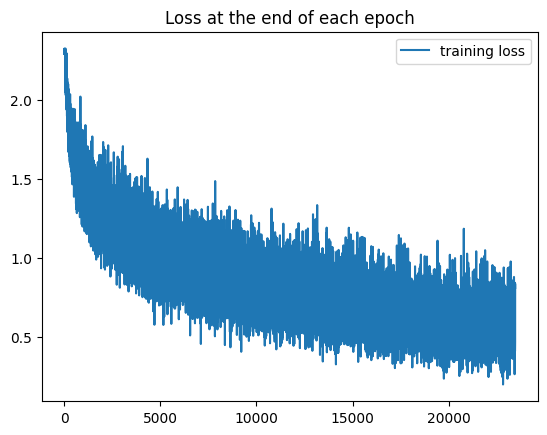

In [ ]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();

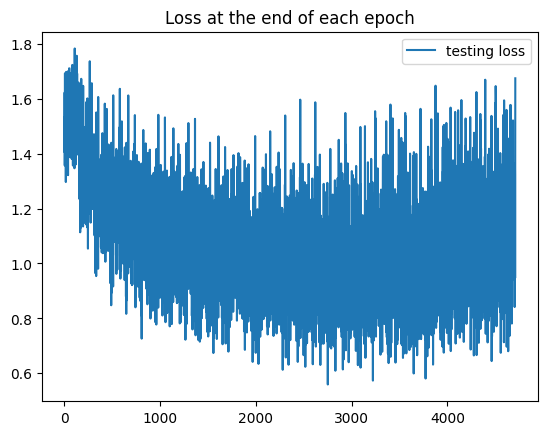

In [ ]:
plt.plot(test_losses, label='testing loss')
plt.title('Loss at the end of each epoch')
plt.legend();

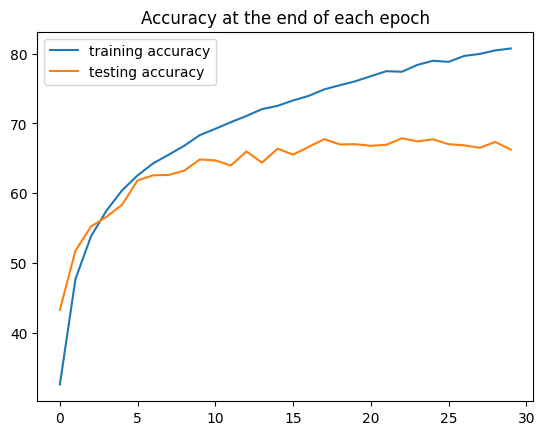

In [ ]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='testing accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

#Workshop on Real Image Data
So far we've only worked with toy datasets (MNIST, CIFAR-10) conveniently packaged by torchvision, where every image has the same size and shape. Now let's learn the real deal, and work from a varied collection of .jpg files.


We have organized the files into <font color='red'>Cat</font> and <font color='red'>Dog</font> folders.
In this way the file path contains the label.



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-09-01 15:49:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  29.6MB/s    in 2.2s    

2024-09-01 15:49:16 (29.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = 'Petimages'
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')

# Create the base directory
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

In [ ]:
import shutil

source_path = '/tmp/cats_and_dogs_filtered/train/cats'
destination_path = '/content/Petimages/Cat'
for filename in os.listdir(source_path):
    source_file = os.path.join(source_path, filename)
    destination_file = os.path.join(destination_path, filename)
    if os.path.isfile(source_file):
        shutil.move(source_file, destination_file)

source_path = '/tmp/cats_and_dogs_filtered/validation/cats'
destination_path = '/content/Petimages/Cat'
for filename in os.listdir(source_path):
    source_file = os.path.join(source_path, filename)
    destination_file = os.path.join(destination_path, filename)
    if os.path.isfile(source_file):
        shutil.move(source_file, destination_file)

source_path = '/tmp/cats_and_dogs_filtered/train/dogs'
destination_path = '/content/Petimages/Dog'
for filename in os.listdir(source_path):
    source_file = os.path.join(source_path, filename)
    destination_file = os.path.join(destination_path, filename)
    if os.path.isfile(source_file):
        shutil.move(source_file, destination_file)

source_path = '/tmp/cats_and_dogs_filtered/validation/dogs'
destination_path = '/content/Petimages/Dog'
for filename in os.listdir(source_path):
    source_file = os.path.join(source_path, filename)
    destination_file = os.path.join(destination_path, filename)
    if os.path.isfile(source_file):
        shutil.move(source_file, destination_file)

### Image files directory tree
<pre>.
└──Petimages
   ├── Cat
   │   ├── 0.jpg
   │   ├── 1.jpg
   │   ├── 10.jpg
   │   ├── 100.jpg
   │   └── ... (12500 files)
   └── Dog
       ├── 0.jpg
       ├── 1.jpg
       ├── 10.jpg
       ├── 100.jpg
       └── ... (12500 files)
</pre>

## Examine the data
We'll us Python's built-in <a href='https://docs.python.org/3/library/os.html'>os module</a> to walk the directories collecting file names. We'll then use <a href='https://python-pillow.org/'>Pillow</a>, an extension to the Python Imaging Library (PIL), to open image files and extract image sizes. A pandas DataFrame will provide summary statistics on our data like max/min width & height from which we can choose our model parameters.

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

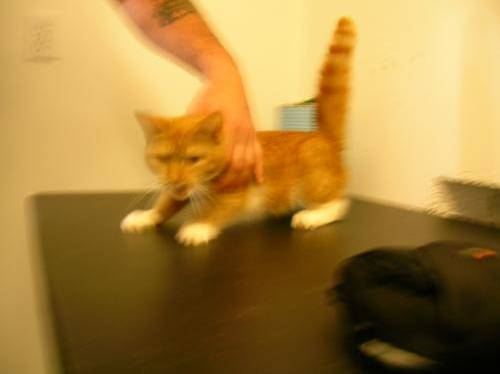

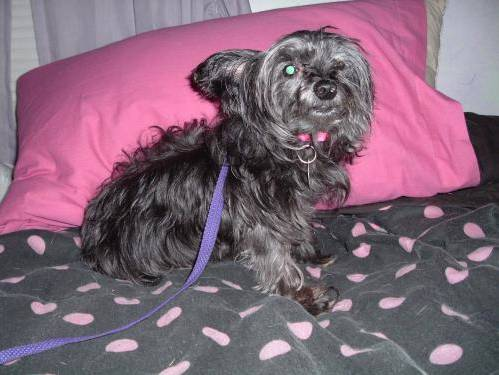

In [ ]:
with Image.open('/content/Petimages/Cat/cat.0.jpg') as im:
    display(im)
with Image.open('/content/Petimages/Dog/dog.0.jpg') as im:
    display(im)

## Prepare train and test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [ ]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data = datasets.ImageFolder('/content/Petimages', transform=transform, is_valid_file=check_Image)

class_names = data.classes
class_names

['Cat', 'Dog']

In [ ]:

train_indices, test_indices, _, _ = train_test_split(
    range(len(data)),
    data.targets,
    stratify=data.targets,
    test_size=0.3,
)

trainset = Subset(data, train_indices)
testset = Subset(data, test_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64)

Create your CNN based on the given architecture:


1. The first layer comprises 32 of 3x3 filters

2. The second layer comprises 16 of 3x3 filters

3. For the module of the fully connected layers, it comprises 4 linear layers with size 128, 64, 32 and 10.

4. In each layer, the ReLU function is performed as the activation function.

5. The max pooling is used in every convolution layers.


<div class="alert alert-info"><strong>NOTE:</strong>  Because images have different size,
<a href='https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html'><tt><strong>Resize</strong></tt></a> must be used to resize images to 224x224.

In [ ]:
#Implement
conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=0) # (input chanel, hidden node, filter size, stride=1, padding=0)
conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=0) # (output chanel 1, hidden node, filter size, stride=1, padding=0)

batch_size = 1
input_tensor = torch.randn(batch_size, 3, 224, 224)

output = conv1(input_tensor)
print("Output shape after conv1:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)

output = conv2(output)
print("Output shape after conv2:", output.shape)

output = F.max_pool2d(output, 2, 2)
print("Output shape after max_pool2d:", output.shape)


Output shape after conv1: torch.Size([1, 32, 222, 222])
Output shape after max_pool2d: torch.Size([1, 32, 111, 111])
Output shape after conv2: torch.Size([1, 16, 109, 109])
Output shape after max_pool2d: torch.Size([1, 16, 54, 54])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.fc1 = nn.Linear(16*54*54, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,10)

    def forward(self, X):
        # feature mapping
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # fully connected
        X = X.view(-1, 16*54*54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X

In [ ]:
model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
            Conv2d-2         [-1, 16, 109, 109]           4,624
            Linear-3                  [-1, 128]       5,972,096
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                   [-1, 10]             330
Total params: 5,988,282
Trainable params: 5,988,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.48
Params size (MB): 22.84
Estimated Total Size (MB): 36.90
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_accuracy = 0
    test_accuracy = 0
    N_train = 0
    for X_train, y_train in trainloader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        N_train += X_train.shape[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        batch_corr = (y_pred.argmax(dim=-1) == y_train).sum()
        train_accuracy += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_losses.append(loss.detach().cpu().numpy())

    # Print  results
    print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: { 100*train_accuracy/N_train   :7.3f}%')

    # Update training accuracy for the epoch
    train_correct.append(100*train_accuracy.item()/N_train)

    # Run the testing batches
    with torch.no_grad():
        N_test = 0
        for X_test, y_test in testloader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            N_test += X_test.shape[0]

            # Apply the model
            y_pred = model(X_test)

            # Tally the number of correct predictions
            test_accuracy += (y_pred.argmax(dim=-1) == y_test).sum()

            # calculate testing loss
            loss = criterion(y_pred, y_test)
            test_losses.append(loss.detach().cpu().numpy())

    # Update testing accuracy for the epoch
    test_correct.append(100*test_accuracy.item()/N_test)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0 loss: 0.70912671 accuracy:  47.714%
epoch:  1 loss: 0.71993411 accuracy:  51.667%
epoch:  2 loss: 0.69761312 accuracy:  54.000%
epoch:  3 loss: 0.70451677 accuracy:  59.095%
epoch:  4 loss: 0.68268734 accuracy:  60.952%
epoch:  5 loss: 0.58730108 accuracy:  64.667%
epoch:  6 loss: 0.62993091 accuracy:  67.000%
epoch:  7 loss: 0.54451519 accuracy:  67.905%
epoch:  8 loss: 0.41695693 accuracy:  71.810%
epoch:  9 loss: 0.45544210 accuracy:  75.238%
epoch: 10 loss: 0.56902170 accuracy:  77.429%
epoch: 11 loss: 0.58386129 accuracy:  77.810%
epoch: 12 loss: 0.32945096 accuracy:  79.143%
epoch: 13 loss: 0.35734528 accuracy:  81.286%
epoch: 14 loss: 0.55419368 accuracy:  85.238%
epoch: 15 loss: 0.40249234 accuracy:  87.619%
epoch: 16 loss: 0.14176431 accuracy:  91.524%
epoch: 17 loss: 0.14055638 accuracy:  91.143%
epoch: 18 loss: 0.07085318 accuracy:  94.000%
epoch: 19 loss: 0.04723820 accuracy:  97.095%

Duration: 271 seconds


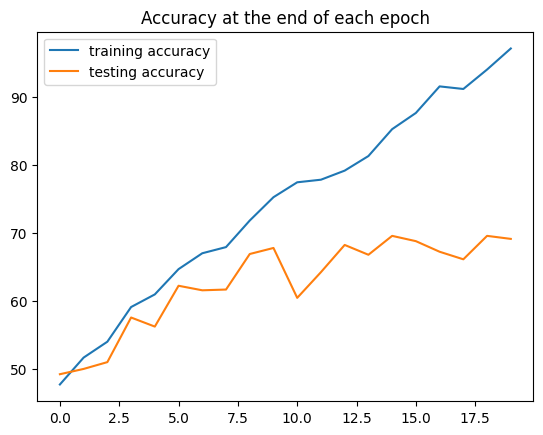

In [ ]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='testing accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
# prompt: export model and save

torch.save(model.state_dict(), 'my_model.pth')
